Generation 0, Pareto front size: 47
Generation 100, Pareto front size: 185
Generation 200, Pareto front size: 185

--- NSGA-II Optimization Complete ---
Pareto Front Size: 174

--- Pareto Front Solutions ---

Solution 1:
  Makespan: 15
  Energy Cost: 4.51
  Tardiness: 0

Solution 2:
  Makespan: 15
  Energy Cost: 4.51
  Tardiness: 0

Solution 3:
  Makespan: 18
  Energy Cost: 4.36
  Tardiness: 6

Solution 4:
  Makespan: 18
  Energy Cost: 4.36
  Tardiness: 6

Solution 5:
  Makespan: 15
  Energy Cost: 4.51
  Tardiness: 0

Solution 6:
  Makespan: 15
  Energy Cost: 4.51
  Tardiness: 0

Solution 7:
  Makespan: 15
  Energy Cost: 4.51
  Tardiness: 0

Solution 8:
  Makespan: 15
  Energy Cost: 4.51
  Tardiness: 0

Solution 9:
  Makespan: 15
  Energy Cost: 4.51
  Tardiness: 0

Solution 10:
  Makespan: 15
  Energy Cost: 4.51
  Tardiness: 0

Solution 11:
  Makespan: 15
  Energy Cost: 4.51
  Tardiness: 0

Solution 12:
  Makespan: 15
  Energy Cost: 4.51
  Tardiness: 0

Solution 13:
  Makespan: 15
  En

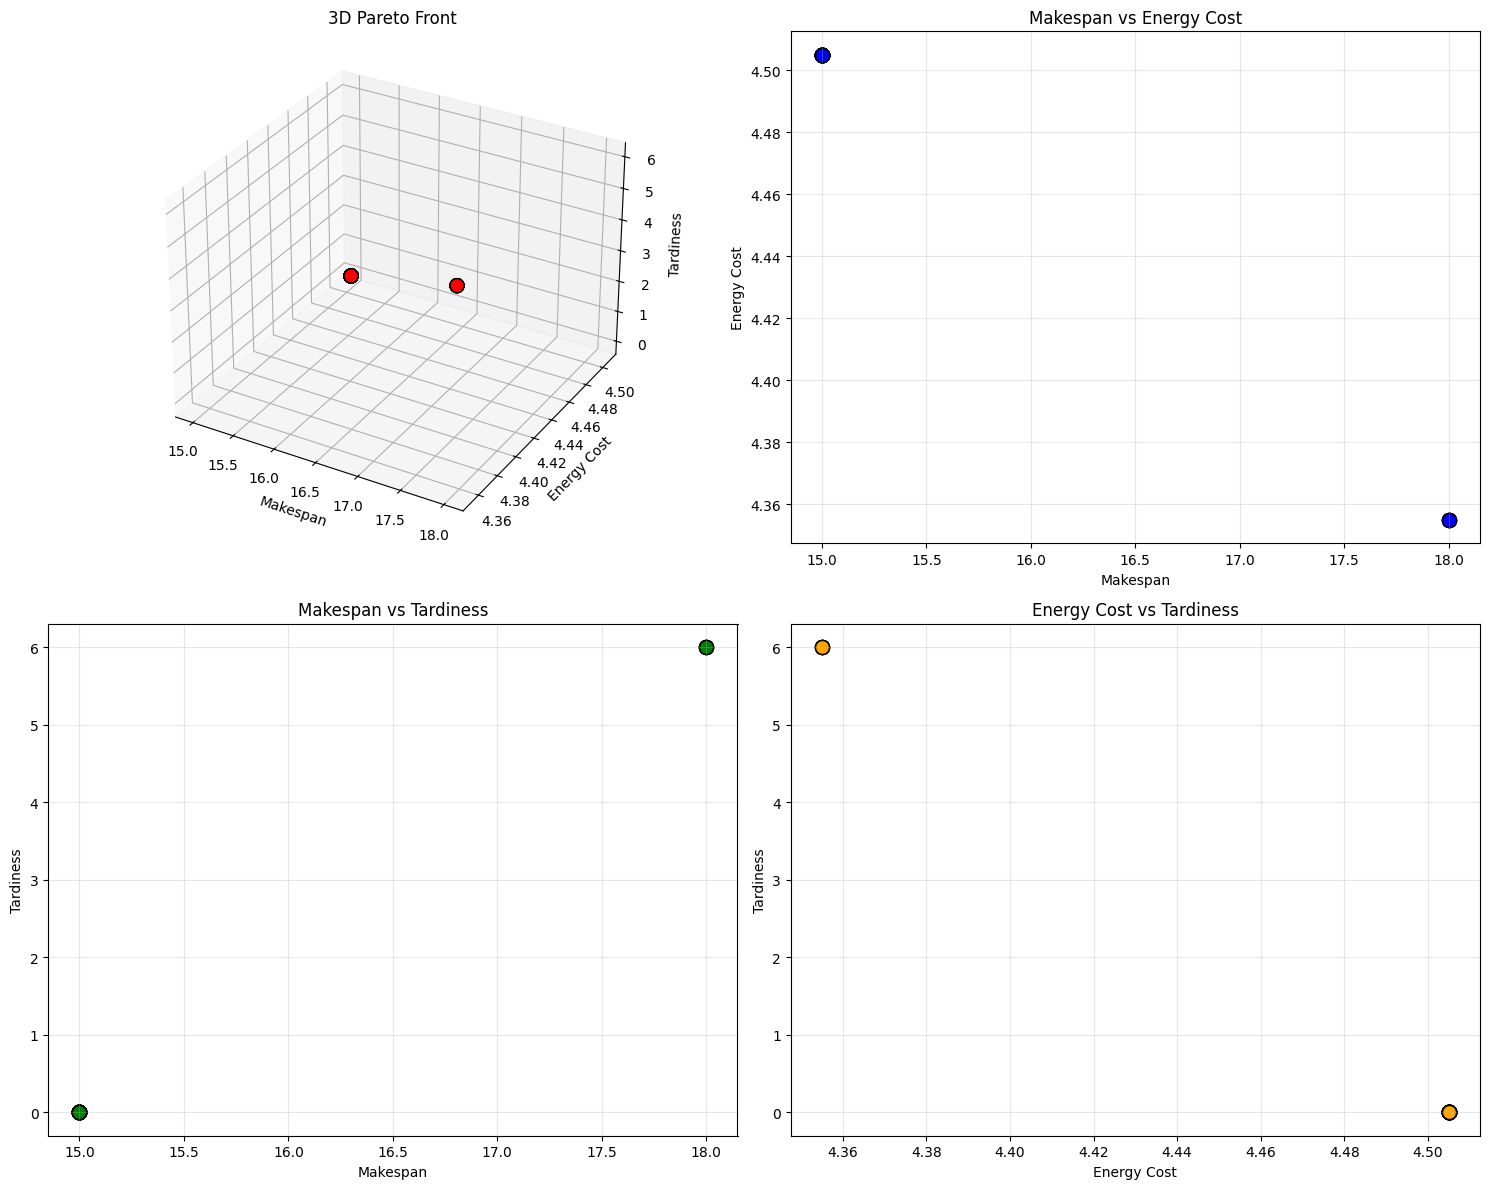

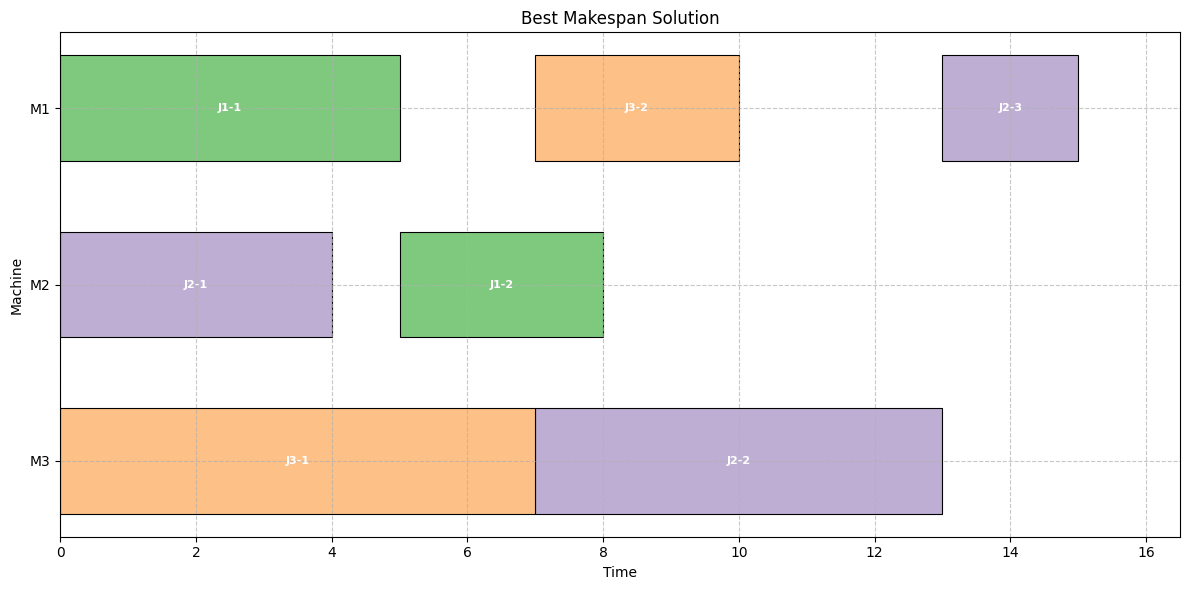

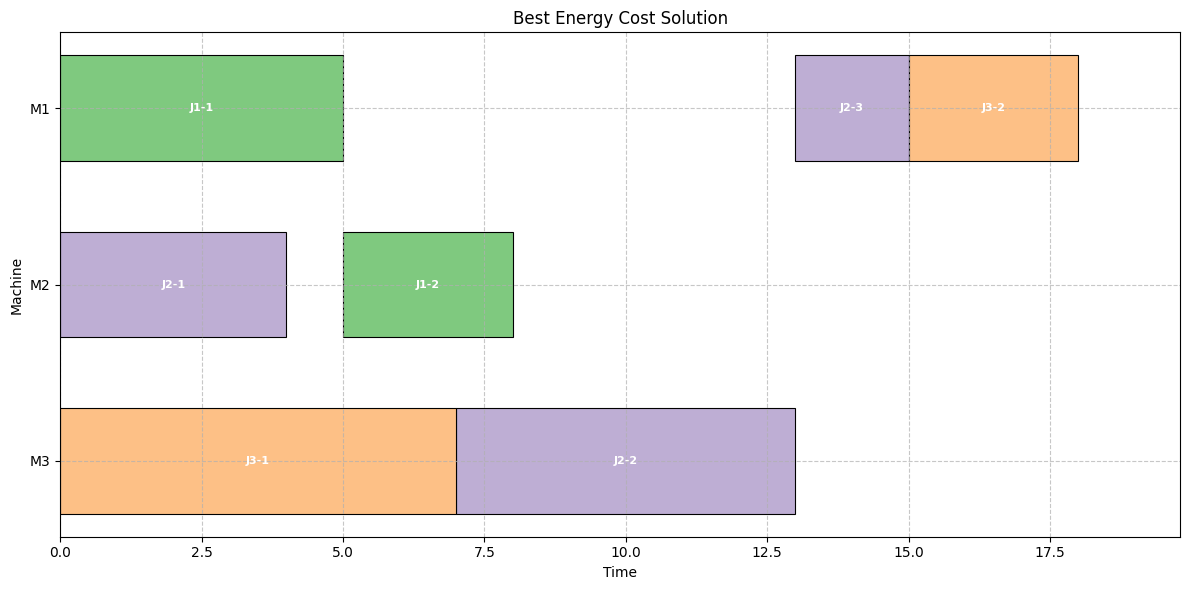

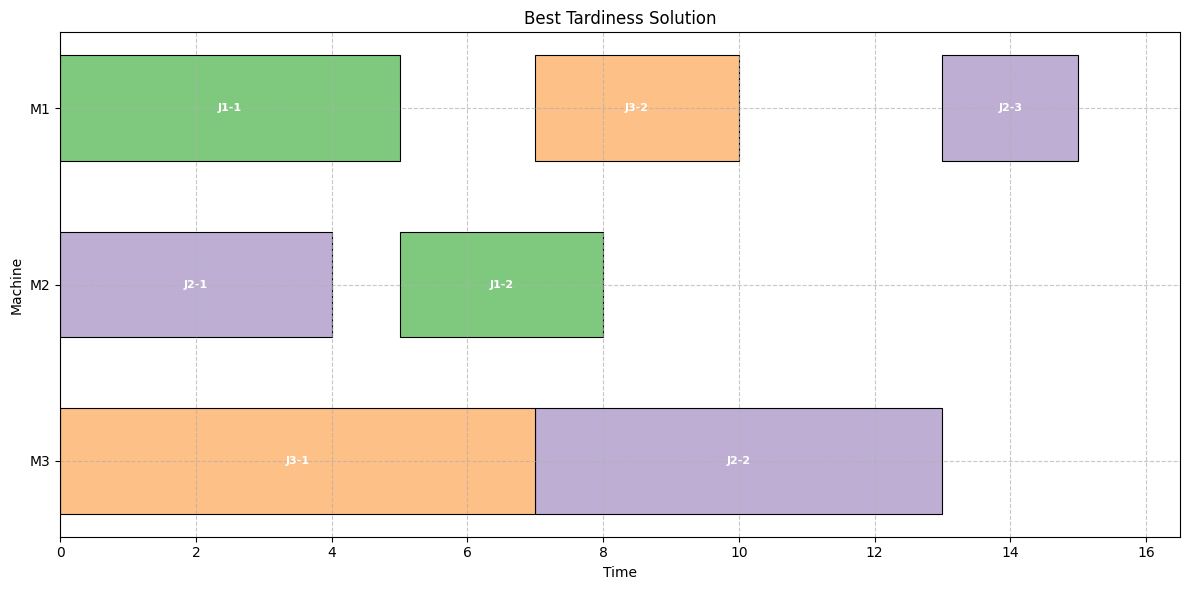

In [1]:
import random
import collections
import copy
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

class Operation:
    """
    Represents a single operation within a job.
    """
    def __init__(self, op_id: str, job_id: str, machine_id: str, processing_time: int, order: int):
        self.op_id = op_id
        self.job_id = job_id
        self.machine_id = machine_id
        self.processing_time = processing_time  # Duration of the operation
        self.order = order  # Order of this operation within its job (e.g., 1st, 2nd)
        self.start_time = -1
        self.end_time = -1
        self.energy_consumption = 0.0 # Energy consumed by this operation

    def __repr__(self):
        return (f"Operation(ID={self.op_id}, Job={self.job_id}, Machine={self.machine_id}, "
                f"Time={self.processing_time}, Order={self.order}, Start={self.start_time}, End={self.end_time})")

    def __eq__(self, other):
        if not isinstance(other, Operation):
            return NotImplemented
        return self.op_id == other.op_id

    def __hash__(self):
        return hash(self.op_id)

class Job:
    """
    Represents a production job, composed of a sequence of operations.
    Now includes a due_date.
    """
    def __init__(self, job_id: str, operations: list[Operation], due_date: int = float('inf')):
        self.job_id = job_id
        # Operations should be ordered correctly, e.g., by their 'order' attribute
        self.operations = sorted(operations, key=lambda op: op.order)
        self.release_time = 0 # Time job becomes available (can be extended)
        self.due_date = due_date # Target completion time

    def __repr__(self):
        return f"Job(ID={self.job_id}, Operations={len(self.operations)}, DueDate={self.due_date})"

class Machine:
    """
    Represents a machine in the job shop.
    Can have different energy consumption rates based on its state (e.g., idle, working).
    """
    def __init__(self, machine_id: str, idle_power: float = 0.5, working_power: float = 1.0):
        self.machine_id = machine_id
        self.idle_power = idle_power  # Power consumption when idle (e.g., kW)
        self.working_power = working_power # Power consumption when working (e.g., kW)
        self.available_time = 0  # Time when the machine becomes free
        self.schedule = [] # List of (start_time, end_time, operation) tuples

    def __repr__(self):
        return f"Machine(ID={self.machine_id}, IdlePower={self.idle_power}, WorkingPower={self.working_power})"

class EnergyCostModel:
    """
    Calculates energy costs based on time-of-use tariffs.
    """
    def __init__(self, tariff_periods: dict[str, tuple[int, int, float]]):
        """
        Initializes the energy cost model.
        :param tariff_periods: Dictionary mapping period names to (start_hour, end_hour, cost_per_unit)
                               e.g., {"peak": (8, 18, 0.20), "off_peak": (0, 8, 0.10)}
        """
        # Sort tariff periods by start hour for easier lookup
        self.tariff_periods = sorted(
            [(start, end, cost) for _, (start, end, cost) in tariff_periods.items()],
            key=lambda x: x[0]
        )

    def get_cost_per_unit(self, time_point: int) -> float:
        """
        Returns the energy cost per unit for a given time point (hour of the day).
        Assumes time_point is an hour (0-23).
        """
        hour = time_point % 24 # Handle wrap-around for continuous time if needed
        for start_hour, end_hour, cost in self.tariff_periods:
            if start_hour <= hour < end_hour:
                return cost
        # Fallback if no period matches (e.g., if periods don't cover 24h or for edge cases)
        return self.tariff_periods[0][2] if self.tariff_periods else 0.0

    def calculate_operation_cost(self, operation: Operation, machine: Machine) -> float:
        """
        Calculates the energy cost for a single operation.
        Assumes discrete time steps (e.g., hours).
        """
        if operation.start_time == -1 or operation.end_time == -1:
            return 0.0 # Operation not scheduled yet

        total_cost = 0.0
        # Iterate through each time unit the operation is active
        for t in range(operation.start_time, operation.end_time):
            cost_per_unit = self.get_cost_per_unit(t)
            total_cost += machine.working_power * cost_per_unit

        return total_cost

class Individual:
    """
    Represents an individual in the NSGA-II population.
    """
    def __init__(self, chromosome: list[str]):
        self.chromosome = chromosome
        self.objectives = None  # Will store [makespan, energy_cost, tardiness]
        self.rank = None
        self.crowding_distance = 0.0
        self.dominates = set()  # Set of individuals this individual dominates
        self.dominated_by = 0   # Number of individuals that dominate this individual

    def dominates_individual(self, other):
        """
        Checks if this individual dominates another individual.
        For minimization: self dominates other if self is better or equal in all objectives
        and strictly better in at least one objective.
        """
        if self.objectives is None or other.objectives is None:
            return False

        better_in_any = False
        for i in range(len(self.objectives)):
            if self.objectives[i] > other.objectives[i]:  # Worse in any objective
                return False
            elif self.objectives[i] < other.objectives[i]:  # Better in this objective
                better_in_any = True

        return better_in_any

class NSGA2Scheduler:
    """
    Implements an energy-aware job shop scheduling algorithm using NSGA-II.
    """
    def __init__(self, jobs: list[Job], machines: list[Machine], energy_model: EnergyCostModel,
                 population_size: int = 150, generations: int = 500,
                 crossover_rate: float = 0.9, mutation_rate: float = 0.2):

        self.jobs = {job.job_id: job for job in jobs}
        self.machines = {machine.machine_id: machine for machine in machines}
        self.energy_model = energy_model

        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

        # Total number of operations for chromosome length
        self.total_operations = sum(len(job.operations) for job in jobs)

        # Pre-calculate total occurrences of each job ID in a chromosome
        self.total_ops_per_job = {job_id: len(job.operations) for job_id, job in self.jobs.items()}

        # Create a flattened list of all operations, ordered by job_id and then operation order
        self.all_operations_flat = []
        for job_id in sorted(self.jobs.keys()):
            self.all_operations_flat.extend(self.jobs[job_id].operations)

        # Map job_id to a list of its operations, for easy access during decoding
        self.job_operations_map = {job_id: collections.deque(job.operations) for job_id, job in self.jobs.items()}

        self.pareto_front = []
        self.best_solutions = []

    def _initialize_population(self) -> list[Individual]:
        """
        Initializes a population with more diverse individuals.
        """
        population = []
        # Create a list of all job IDs, repeated by their number of operations
        job_ids_for_permutation = []
        for job_id, job in self.jobs.items():
            job_ids_for_permutation.extend([job_id] * len(job.operations))

        # Create diverse initial population
        for i in range(self.population_size):
            chromosome = list(job_ids_for_permutation)

            if i < self.population_size // 4:
                # 25% completely random
                random.shuffle(chromosome)
            elif i < self.population_size // 2:
                # 25% with job-priority bias (earlier jobs first)
                job_priorities = {job_id: random.random() for job_id in self.jobs.keys()}
                chromosome.sort(key=lambda x: job_priorities[x])
            elif i < 3 * self.population_size // 4:
                # 25% with shortest processing time first
                op_times = {}
                for job_id, job in self.jobs.items():
                    op_times[job_id] = sum(op.processing_time for op in job.operations)
                chromosome.sort(key=lambda x: op_times[x])
            else:
                # 25% with due date priority
                chromosome.sort(key=lambda x: self.jobs[x].due_date)

            # Add some randomness to non-random methods
            if i >= self.population_size // 4:
                # Perform some swaps to add diversity
                for _ in range(len(chromosome) // 10):
                    idx1, idx2 = random.sample(range(len(chromosome)), 2)
                    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]

            individual = Individual(chromosome)
            population.append(individual)
        return population

    def _decode_chromosome(self, chromosome: list[str]) -> tuple[list[Operation], int, float, int]:
        """
        Decodes a chromosome (permutation of job IDs) into a feasible schedule.
        Calculates makespan, total energy cost, and total tardiness.
        """
        # Reset machine availability for this decoding run
        machine_available_time = {machine_id: 0 for machine_id in self.machines}

        # Keep track of the next operation index for each job in the chromosome sequence
        job_next_op_counts = {job_id: 0 for job_id in self.jobs}

        # Store completion times for each operation within a job for precedence
        job_op_completion_times = {job_id: {op.order: 0 for op in job.operations} for job_id, job in self.jobs.items()}

        # Create a deep copy of operations to store the schedule for this chromosome
        scheduled_operations = []

        # Create a temporary map of operations for quick lookup by (job_id, order)
        temp_ops_map = {}
        for job_id, job in self.jobs.items():
            for op in job.operations:
                # Create a fresh copy of the operation for this decoding
                new_op = Operation(op.op_id, op.job_id, op.machine_id, op.processing_time, op.order)
                temp_ops_map[(new_op.job_id, new_op.order)] = new_op
                scheduled_operations.append(new_op)

        # Sort scheduled_operations by op_id to ensure consistent iteration for result
        scheduled_operations.sort(key=lambda op: op.op_id)

        # Iterate through the chromosome (sequence of job IDs)
        for job_id_in_chromosome in chromosome:
            # Get the current operation for this job based on its sequence in the chromosome
            op_order_in_job = job_next_op_counts[job_id_in_chromosome] + 1
            current_op = temp_ops_map[(job_id_in_chromosome, op_order_in_job)]

            machine = self.machines[current_op.machine_id]

            # Calculate earliest possible start time
            earliest_start_on_machine = machine_available_time[current_op.machine_id]

            # Predecessor operation completion time (within the same job)
            predecessor_completion_time = 0
            if current_op.order > 1:
                predecessor_completion_time = job_op_completion_times[current_op.job_id][current_op.order - 1]

            # Job release time
            job_release_time = self.jobs[current_op.job_id].release_time

            start_time = max(earliest_start_on_machine, predecessor_completion_time, job_release_time)

            current_op.start_time = start_time
            current_op.end_time = start_time + current_op.processing_time

            # Update machine availability
            machine_available_time[current_op.machine_id] = current_op.end_time

            # Update job operation completion time for subsequent operations in the same job
            job_op_completion_times[current_op.job_id][current_op.order] = current_op.end_time

            # Calculate energy consumption for this operation
            current_op.energy_consumption = self.energy_model.calculate_operation_cost(current_op, machine)

            # Increment the count for the next operation of this job
            job_next_op_counts[job_id_in_chromosome] += 1

        # Calculate objectives
        makespan = max(op.end_time for op in scheduled_operations) if scheduled_operations else 0
        total_energy_cost = sum(op.energy_consumption for op in scheduled_operations)

        # Calculate total tardiness
        total_tardiness = 0
        job_completion_times = {job_id: 0 for job_id in self.jobs}
        for op in scheduled_operations:
            job_completion_times[op.job_id] = max(job_completion_times[op.job_id], op.end_time)

        for job_id, completion_time in job_completion_times.items():
            job = self.jobs[job_id]
            if completion_time > job.due_date:
                total_tardiness += (completion_time - job.due_date)

        return scheduled_operations, makespan, total_energy_cost, total_tardiness

    def _evaluate_population(self, population: list[Individual]):
        """
        Evaluates the objectives for each individual in the population.
        """
        for individual in population:
            _, makespan, energy_cost, tardiness = self._decode_chromosome(individual.chromosome)
            individual.objectives = [makespan, energy_cost, tardiness]

    def _fast_non_dominated_sort(self, population: list[Individual]) -> list[list[Individual]]:
        """
        Performs fast non-dominated sorting and returns fronts.
        """
        # Reset domination relationships for all individuals
        for individual in population:
            individual.dominates = set()
            individual.dominated_by = 0
            individual.rank = None  # Reset rank

        # Calculate domination relationships
        for i, individual in enumerate(population):
            for j, other in enumerate(population):
                if i != j:  # Don't compare with itself
                    if individual.dominates_individual(other):
                        individual.dominates.add(other)
                    elif other.dominates_individual(individual):
                        individual.dominated_by += 1

        # Create fronts
        fronts = []
        current_front = []

        # First front: individuals with dominated_by = 0
        for individual in population:
            if individual.dominated_by == 0:
                individual.rank = 0
                current_front.append(individual)

        fronts.append(current_front)

        # Generate subsequent fronts
        front_index = 0
        while len(fronts[front_index]) > 0:
            next_front = []
            for individual in fronts[front_index]:
                for dominated_individual in individual.dominates:
                    dominated_individual.dominated_by -= 1
                    if dominated_individual.dominated_by == 0:
                        dominated_individual.rank = front_index + 1
                        next_front.append(dominated_individual)
            fronts.append(next_front)
            front_index += 1

        return fronts[:-1]  # Remove the last empty front

    def _calculate_crowding_distance(self, front: list[Individual]):
        """
        Calculates crowding distance for individuals in a front.
        """
        if len(front) == 0:
            return

        num_objectives = len(front[0].objectives)

        # Initialize crowding distance
        for individual in front:
            individual.crowding_distance = 0

        # Calculate crowding distance for each objective
        for obj_index in range(num_objectives):
            # Sort by objective value
            front.sort(key=lambda ind: ind.objectives[obj_index])

            # Set boundary points to infinite distance
            front[0].crowding_distance = float('inf')
            front[-1].crowding_distance = float('inf')

            # Calculate distance for intermediate points
            if len(front) > 2:
                obj_range = front[-1].objectives[obj_index] - front[0].objectives[obj_index]
                if obj_range > 0:  # Avoid division by zero
                    for i in range(1, len(front) - 1):
                        distance = (front[i + 1].objectives[obj_index] - front[i - 1].objectives[obj_index]) / obj_range
                        front[i].crowding_distance += distance

    def _tournament_selection(self, population: list[Individual]) -> Individual:
        """
        Tournament selection based on rank and crowding distance.
        """
        tournament_size = 3  # Increased tournament size
        tournament = random.sample(population, tournament_size)

        # Select based on rank first, then crowding distance
        winner = tournament[0]
        for individual in tournament[1:]:
            # Check if rank is not None before comparison
            if (individual.rank is not None and winner.rank is not None and
                (individual.rank < winner.rank or
                 (individual.rank == winner.rank and individual.crowding_distance > winner.crowding_distance))):
                winner = individual
            elif individual.rank is not None and winner.rank is None:
                winner = individual

        return winner

    def _crossover(self, parent1: Individual, parent2: Individual) -> tuple[Individual, Individual]:
        """
        Order Crossover (OX1) for permutations with repeated elements.
        """
        if random.random() > self.crossover_rate:
            return Individual(parent1.chromosome.copy()), Individual(parent2.chromosome.copy())

        size = len(parent1.chromosome)
        child1_chrom, child2_chrom = [None] * size, [None] * size

        # Select two random cut points
        start, end = sorted(random.sample(range(size), 2))

        # Copy segment from parent1 to child1, and parent2 to child2
        child1_chrom[start:end+1] = parent1.chromosome[start:end+1]
        child2_chrom[start:end+1] = parent2.chromosome[start:end+1]

        # Helper function to fill the remaining positions in a child
        def fill_remaining(target_child, source_parent, total_ops_per_job, segment_start, segment_end):
            # Create a counter for elements already present in the target_child's fixed segment
            current_child_counts = collections.Counter(target_child[segment_start:segment_end+1])

            # Collect elements from source_parent that are needed to fill the child
            elements_to_place = []
            for element in source_parent:
                if current_child_counts[element] < total_ops_per_job[element]:
                    elements_to_place.append(element)
                    current_child_counts[element] += 1

            # Fill the None slots in target_child with elements_to_place
            fill_idx = 0
            for i in range(size):
                if target_child[i] is None:
                    target_child[i] = elements_to_place[fill_idx]
                    fill_idx += 1

        # Fill remaining positions
        fill_remaining(child1_chrom, parent2.chromosome, self.total_ops_per_job, start, end)
        fill_remaining(child2_chrom, parent1.chromosome, self.total_ops_per_job, start, end)

        return Individual(child1_chrom), Individual(child2_chrom)

    def _mutate(self, individual: Individual) -> Individual:
        """
        Enhanced mutation with multiple strategies.
        """
        chromosome = individual.chromosome.copy()

        # Multiple mutation strategies
        if random.random() < self.mutation_rate:
            mutation_type = random.choice(['swap', 'insertion', 'inversion'])

            if mutation_type == 'swap':
                # Swap mutation
                idx1, idx2 = random.sample(range(len(chromosome)), 2)
                chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]

            elif mutation_type == 'insertion':
                # Insertion mutation
                idx1 = random.randint(0, len(chromosome) - 1)
                idx2 = random.randint(0, len(chromosome) - 1)
                if idx1 != idx2:
                    element = chromosome.pop(idx1)
                    chromosome.insert(idx2, element)

            elif mutation_type == 'inversion':
                # Inversion mutation
                idx1, idx2 = sorted(random.sample(range(len(chromosome)), 2))
                chromosome[idx1:idx2+1] = reversed(chromosome[idx1:idx2+1])

        return Individual(chromosome)

    def run(self) -> dict:
        """
        Runs the NSGA-II algorithm to find Pareto-optimal solutions.
        """
        # Initialize population
        population = self._initialize_population()

        # Evaluate initial population
        self._evaluate_population(population)

        for generation in range(self.generations):
            # Fast non-dominated sorting
            fronts = self._fast_non_dominated_sort(population)

            # Calculate crowding distance for each front
            for front in fronts:
                self._calculate_crowding_distance(front)

            # Create offspring
            offspring = []
            for _ in range(self.population_size // 2):
                parent1 = self._tournament_selection(population)
                parent2 = self._tournament_selection(population)
                child1, child2 = self._crossover(parent1, parent2)
                child1 = self._mutate(child1)
                child2 = self._mutate(child2)
                offspring.extend([child1, child2])

            # Evaluate offspring
            self._evaluate_population(offspring)

            # Combine parent and offspring populations
            combined_population = population + offspring

            # Fast non-dominated sorting for combined population
            fronts = self._fast_non_dominated_sort(combined_population)

            # Calculate crowding distance for each front
            for front in fronts:
                self._calculate_crowding_distance(front)

            # Select next generation
            next_population = []
            for front in fronts:
                if len(next_population) + len(front) <= self.population_size:
                    next_population.extend(front)
                else:
                    # Sort by crowding distance and select the best
                    front.sort(key=lambda ind: ind.crowding_distance, reverse=True)
                    remaining = self.population_size - len(next_population)
                    next_population.extend(front[:remaining])
                    break

            population = next_population

            # Update Pareto front (first front)
            if fronts:
                self.pareto_front = fronts[0]

            if generation % 100 == 0:
                print(f"Generation {generation}, Pareto front size: {len(self.pareto_front)}")

        # Prepare results
        self.best_solutions = []
        for individual in self.pareto_front:
            scheduled_ops, makespan, energy_cost, tardiness = self._decode_chromosome(individual.chromosome)
            solution = {
                "chromosome": individual.chromosome,
                "scheduled_operations": scheduled_ops,
                "makespan": makespan,
                "total_energy_cost": energy_cost,
                "total_tardiness": tardiness,
                "objectives": individual.objectives
            }
            self.best_solutions.append(solution)

        print(f"\n--- NSGA-II Optimization Complete ---")
        print(f"Pareto Front Size: {len(self.pareto_front)}")

        return {
            "pareto_front": self.best_solutions,
            "best_makespan": min(sol["makespan"] for sol in self.best_solutions),
            "best_energy": min(sol["total_energy_cost"] for sol in self.best_solutions),
            "best_tardiness": min(sol["total_tardiness"] for sol in self.best_solutions)
        }

def plot_pareto_front(solutions: list[dict]):
    """
    Plots the Pareto front in 3D space with enhanced visualization.
    """
    if not solutions:
        print("No solutions to plot")
        return

    print(f"Plotting {len(solutions)} solutions in the Pareto front")

    fig = plt.figure(figsize=(15, 12))

    # 3D scatter plot
    ax1 = fig.add_subplot(221, projection='3d')
    makespans = [sol["makespan"] for sol in solutions]
    energy_costs = [sol["total_energy_cost"] for sol in solutions]
    tardiness = [sol["total_tardiness"] for sol in solutions]

    ax1.scatter(makespans, energy_costs, tardiness, c='red', s=100, alpha=0.8, edgecolors='black')
    ax1.set_xlabel('Makespan')
    ax1.set_ylabel('Energy Cost')
    ax1.set_zlabel('Tardiness')
    ax1.set_title('3D Pareto Front')

    # 2D projections
    ax2 = fig.add_subplot(222)
    ax2.scatter(makespans, energy_costs, c='blue', s=100, alpha=0.8, edgecolors='black')
    ax2.set_xlabel('Makespan')
    ax2.set_ylabel('Energy Cost')
    ax2.set_title('Makespan vs Energy Cost')
    ax2.grid(True, alpha=0.3)

    ax3 = fig.add_subplot(223)
    ax3.scatter(makespans, tardiness, c='green', s=100, alpha=0.8, edgecolors='black')
    ax3.set_xlabel('Makespan')
    ax3.set_ylabel('Tardiness')
    ax3.set_title('Makespan vs Tardiness')
    ax3.grid(True, alpha=0.3)

    ax4 = fig.add_subplot(224)
    ax4.scatter(energy_costs, tardiness, c='orange', s=100, alpha=0.8, edgecolors='black')
    ax4.set_xlabel('Energy Cost')
    ax4.set_ylabel('Tardiness')
    ax4.set_title('Energy Cost vs Tardiness')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_gantt_chart(scheduled_operations: list[Operation], machines: list[Machine], makespan: int, title: str = "Gantt Chart"):
    """
    Plots a Gantt chart for the given scheduled operations.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Map machine IDs to numerical y-coordinates
    machine_ids = sorted([m.machine_id for m in machines])
    machine_y_pos = {machine_id: i for i, machine_id in enumerate(machine_ids)}
    y_ticks = list(machine_y_pos.values())
    y_labels = list(machine_y_pos.keys())

    # Generate unique colors for each job
    job_ids = sorted(list(set(op.job_id for op in scheduled_operations)))
    colors = plt.get_cmap('Accent')
    job_colors = {job_id: colors(i) for i, job_id in enumerate(job_ids)}

    # Plot each operation as a horizontal bar
    for op in scheduled_operations:
        machine_idx = machine_y_pos[op.machine_id]
        duration = op.processing_time
        start = op.start_time

        # Plot the bar
        ax.barh(machine_idx, duration, left=start, height=0.6,
                color=job_colors[op.job_id], edgecolor='black', linewidth=0.8)

        # Add text label (Job ID - Op ID) on the bar
        ax.text(start + duration / 2, machine_idx, f"{op.job_id}-{op.order}",
                ha='center', va='center', color='white', fontsize=8, weight='bold')

    # Set labels and title
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title(title)

    # Set y-axis ticks and labels
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # Set x-axis limits
    ax.set_xlim(0, makespan * 1.1)

    # Invert y-axis to have Machine 1 at the top
    ax.invert_yaxis()

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# --- Enhanced Example with More Jobs and Machines ---
if __name__ == "__main__":
    # 1. Define More Machines with Different Energy Profiles
    machines = [
        Machine("M1", idle_power=0.1, working_power=1.0),
        Machine("M2", idle_power=0.15, working_power=1.5),
        Machine("M3", idle_power=0.08, working_power=0.8),
    ]

    # 2. Define Jobs and their Operations with Due Dates
    # Job 1: Op1 (M1, 5), Op2 (M2, 3). Due Date: 10
    op1_1 = Operation("Op1.1", "J1", "M1", 5, 1)
    op1_2 = Operation("Op1.2", "J1", "M2", 3, 2)
    job1 = Job("J1", [op1_1, op1_2], due_date=10)

    # Job 2: Op1 (M2, 4), Op2 (M3, 6), Op3 (M1, 2). Due Date: 15
    op2_1 = Operation("Op2.1", "J2", "M2", 4, 1)
    op2_2 = Operation("Op2.2", "J2", "M3", 6, 2)
    op2_3 = Operation("Op2.3", "J2", "M1", 2, 3)
    job2 = Job("J2", [op2_1, op2_2, op2_3], due_date=15)

    # Job 3: Op1 (M3, 7), Op2 (M1, 3). Due Date: 12
    op3_1 = Operation("Op3.1", "J3", "M3", 7, 1)
    op3_2 = Operation("Op3.2", "J3", "M1", 3, 2)
    job3 = Job("J3", [op3_1, op3_2], due_date=12)

    all_jobs = [job1, job2, job3]

    # 3. Define Energy Cost Model
    energy_tariffs = {
        "off_peak_night": (0, 7, 0.10),
        "peak_morning": (7, 12, 0.25),
        "off_peak_midday": (12, 17, 0.15),
        "peak_evening": (17, 22, 0.30),
        "off_peak_late": (22, 24, 0.12),
    }
    energy_model = EnergyCostModel(energy_tariffs)

    # 4. Create and Run the NSGA-II Scheduler
    nsga2_scheduler = NSGA2Scheduler(
        all_jobs, machines, energy_model,
        population_size=100,
        generations=300,
        crossover_rate=0.8,
        mutation_rate=0.1
    )

    results = nsga2_scheduler.run()

    # 5. Display Results
    print("\n--- Pareto Front Solutions ---")
    for i, solution in enumerate(results["pareto_front"]):
        print(f"\nSolution {i+1}:")
        print(f"  Makespan: {solution['makespan']}")
        print(f"  Energy Cost: {solution['total_energy_cost']:.2f}")
        print(f"  Tardiness: {solution['total_tardiness']}")

    print(f"\nBest individual objectives:")
    print(f"  Best Makespan: {results['best_makespan']}")
    print(f"  Best Energy Cost: {results['best_energy']:.2f}")
    print(f"  Best Tardiness: {results['best_tardiness']}")

    # 6. Plot Pareto Front
    plot_pareto_front(results["pareto_front"])

    # 7. Plot Gantt charts for a few representative solutions
    if results["pareto_front"]:
        # Plot the solution with best makespan
        best_makespan_sol = min(results["pareto_front"], key=lambda x: x["makespan"])
        plot_gantt_chart(best_makespan_sol["scheduled_operations"], machines,
                        best_makespan_sol["makespan"], "Best Makespan Solution")

        # Plot the solution with best energy cost
        best_energy_sol = min(results["pareto_front"], key=lambda x: x["total_energy_cost"])
        plot_gantt_chart(best_energy_sol["scheduled_operations"], machines,
                        best_energy_sol["makespan"], "Best Energy Cost Solution")

        # Plot the solution with best tardiness
        best_tardiness_sol = min(results["pareto_front"], key=lambda x: x["total_tardiness"])
        plot_gantt_chart(best_tardiness_sol["scheduled_operations"], machines,
                        best_tardiness_sol["makespan"], "Best Tardiness Solution")